In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings

# Set the default font to Arial
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

# Parameters

In [3]:
# The filtering based on hotspots.
# filter_version = 'including'  # 'including', 'excluding', 'only'
list_filter_versions = ['including', 'excluding', 'only']

INDEL_PREFIX = {
        'including':'indels/indels.denovo_', 
        'excluding':'indels/indels.exclHotspots.denovo_', 
        'only':'indels/indels.onlyHotspots.denovo_' 
    }#[filter_version]

FREQS_PREFIX = {
        'including':'tables/freqs.denovo_indels.', 
        'excluding':'tables/freqs.exclHotspots.', 
        'only':'tables/freqs.onlyHotspots.' 
    }#[filter_version]


# The 3 species.
list_species = ['mouse','macaque','human']
# The alignment chosen.
alignment = 'chrM'

# Import indels for 3 species (already annotated with D-loop)

In [4]:
def get_indels(filter_version):
    # Combine indels for the three species.
    INDEL_PREFIX = {
        'including':'indels/indels.denovo_', 
        'excluding':'indels/indels.exclHotspots.denovo_', 
        'only':'indels/indels.onlyHotspots.denovo_' 
    }
    list_df = []
    for species in list_species:
        df = pd.read_table( f'{INDEL_PREFIX[filter_version]}{alignment}_{species}.tab' )
        list_df.append( df )
    df_indels = pd.concat(list_df)

    # Classify as Insertion or Deletion.
    df_indels['Mutation_type'] = np.where(
        df_indels['REF'].str.len() > df_indels['ALT'].str.len(), 'Deletion',
        np.where(df_indels['REF'].str.len() < df_indels['ALT'].str.len(), 'Insertion', 'Other')
    )

    # Indel length.
    df_indels['Change_in_length'] = df_indels['ALT'].str.len() - df_indels['REF'].str.len()

    return df_indels



df_ex = get_indels('excluding')
df_only = get_indels('only')
df_inc = get_indels('including')

df_ex

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Tissue_type,Classification,Mutation_ID,Pedigree_shared,Filter_ID,Region,Region_size,Individuals_Share,Mutation_type,Change_in_length
0,chrM,12343,AT,A,SB=2.42169;AF=0.00495049;AC=0,SRR10068699,.:1:0.00495049:2.42169,mouse,1.0,0.004950,...,germline,Germline de novo,12343_AT_A,Unique to Individual,G133p4_12343,non-D-loop,15423,1,Deletion,-1
1,chrM,14806,CACCCCTACTATACAATCAAAGATATCCTAGGTATCCTAATCATAT...,C,SB=2.57858;AF=0.000629327;AC=0,SRR10068701,.:1:0.000629327:2.57858,mouse,1.0,0.000629,...,germline,Germline de novo,14806_CACCCCTACTATACAATCAAAGATATCCTAGGTATCCTAA...,Unique to Individual,G133p4_14806,non-D-loop,15423,1,Deletion,-58
2,chrM,14640,A,AG,SB=1.61939;AF=0.00191388;AC=0,SRR10068702,.:2:0.00191388:1.61939,mouse,2.0,0.001914,...,somatic,Somatic de novo,14640_A_AG,Unique to Individual,G133p4_14640,non-D-loop,15423,1,Insertion,1
3,chrM,9841,G,GT,SB=2.14678;AF=0.00152439;AC=0,SRR10068710,.:1:0.00152439:2.14678,mouse,1.0,0.001524,...,germline,Germline de novo,9841_G_GT,Unique to Individual,G133p3_9841,non-D-loop,15423,1,Insertion,1
4,chrM,2454,TG,T,SB=1.67393;AF=0.00131406;AC=0,SRR10068715,.:1:0.00131406:1.67393,mouse,1.0,0.001314,...,somatic,Somatic de novo,2454_TG_T,Unique to Individual,G133p1_2454,non-D-loop,15423,1,Deletion,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,chrM,864,A,AATGTT,SB=2.38069;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38069,human,1.0,0.000582,...,germline,Germline de novo,864_A_AATGTT,NaN,hs006_864,non-D-loop,15447,1,Insertion,5
114,chrM,865,ACCCC,A,SB=2.38183;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38183,human,1.0,0.000582,...,germline,Germline de novo,865_ACCCC_A,NaN,hs006_865,non-D-loop,15447,1,Deletion,-4
115,chrM,954,A,AAT,SB=1.92242;AF=0.00256082;AC=0,hs010_Oo6,.:2:0.00256082:1.92242,human,2.0,0.002561,...,germline,Germline de novo,954_A_AAT,NaN,hs010_954,non-D-loop,15447,1,Insertion,2
116,chrM,960,TCCC,T,SB=1.79519;AF=0.00258065;AC=0,hs010_Oo6,.:2:0.00258065:1.79519,human,2.0,0.002581,...,germline,Germline de novo,960_TCCC_T,NaN,hs010_960,non-D-loop,15447,1,Deletion,-3


# Import annotations and seq depths

In [5]:
def get_annots():
    annots = pd.read_table(f"tables/annotations.seqDepth.{alignment}.txt")
    return annots

annots = get_annots()
annots



,SRR_ID,Sample_ID,Individual,Tissue,Tissue_alt,Species,Age_group,Age,MeanReadDepth,Nucleotides
0,SRR10068699,G133p4_Oo2,G133p4,Oo,Oo2,mouse,Younger,0.083333,143.790061,2343778
1,SRR10068701,G133p4_Oo,G133p4,Oo,Oo,mouse,Younger,0.083333,1627.007669,26520225
2,SRR10068702,G133p4_M,G133p4,M,M,mouse,Younger,0.083333,1146.431288,18686830
3,SRR10068703,G133p4_Br,G133p4,Br,Br,mouse,Younger,0.083333,698.298712,11382269
4,SRR10068705,G133p3_Oo3,G133p3,Oo,Oo3,mouse,Younger,0.083333,116.046564,1891559
...,...,...,...,...,...,...,...,...,...,...
489,hs023_Oo1,hs023_Oo1,hs023,Oo,Oo1,human,Intermediate,33.000000,1959.128734,32460804
490,hs023_Oo2,hs023_Oo2,hs023,Oo,Oo2,human,Intermediate,33.000000,1087.038083,18011134
491,hs023_Oo3,hs023_Oo3,hs023,Oo,Oo3,human,Intermediate,33.000000,2201.843020,36482337
492,hs023_Oo4,hs023_Oo4,hs023,Oo,Oo4,human,Intermediate,33.000000,1130.984127,18739276


# Compute mutation frequencies by individual

In [6]:
def get_indiv_freqs(df_indels):
    # Species-specific genome size and ranges from species_info
    species_info = {
        'mouse': {'Dloop_range': (15424, 16300), 'non_Dloop_range': (1, 15423), 'Dloop_size': 877, 'genome_size': 16300},
        'macaque': {'Dloop_range': (16015, 16564), 'non_Dloop_range': (536, 16014), 'Dloop_size': 1085, 'genome_size': 16564},
        'human': {'Dloop_range': (16024, 16569), 'non_Dloop_range': (577, 16023), 'Dloop_size': 1122, 'genome_size': 16569}
    }
    # genome_size = species_info[species]['genome_size']

    # Map genome_size from species_info to the Genome_size column in df_indels
    df_indels['Genome_size'] = df_indels['Species'].map(lambda sp: species_info.get(sp, {}).get('genome_size', None))
    df_indels['Size_Dloop'] = df_indels['Species'].map(lambda sp: species_info.get(sp, {}).get('Dloop_size', None))
    df_indels['Size_nonDloop'] = df_indels['Genome_size'] - df_indels['Size_Dloop']

    # Import annotations.
    annots = get_annots()
    # Map genome_size from species_info to the Genome_size column in annots
    annots['Genome_size'] = annots['Species'].map(lambda sp: species_info.get(sp, {}).get('genome_size', None))
    annots['Size_Dloop'] = annots['Species'].map(lambda sp: species_info.get(sp, {}).get('Dloop_size', None))
    annots['Size_nonDloop'] = annots['Genome_size'] - annots['Size_Dloop']
    # Compute nucleoptides per region.
    annots['Nucleotides_Dloop'] = (annots['MeanReadDepth'] * annots['Size_Dloop']).astype(int)
    annots['Nucleotides_nonDloop'] = (annots['MeanReadDepth'] * annots['Size_nonDloop']).astype(int)
    annots['Nucleotides_total'] = annots['Nucleotides_Dloop'] + annots['Nucleotides_nonDloop']
    # Sum nucleotides per condition (age group, tissue) and individual.
    sort_cols = ['Species', 'Tissue', 'Individual']
    nucl = annots[ sort_cols + ['Nucleotides_total','Nucleotides_Dloop','Nucleotides_nonDloop'] ].groupby(sort_cols).sum().reset_index()

    # Compute the total genome frequencies by grouping by the same columns as the D-loop and non-D-loop frequencies
    no_mutx = df_indels.groupby(['Species', 'Tissue', 'Individual', 'Region']).size().reset_index(name='No_mutations')
    dict_dloop_names = {'D-loop':'Dloop', 'non-D-loop':'nonDloop'}
    no_mutx = no_mutx.pivot_table(index=['Species', 'Tissue', 'Individual'], columns='Region', values='No_mutations', fill_value=0).reset_index()
    no_mutx.columns = ['Mutations_' + str(dict_dloop_names[col]) if col not in ['Species', 'Tissue', 'Individual'] else col for col in no_mutx.columns]
    no_mutx = no_mutx.assign(Mutations_total=no_mutx.filter(like='Mutations_').sum(axis=1))

    # Merge mutations and nucleotides.
    indiv_freqs = pd.merge(nucl,no_mutx, how='left')
    indiv_freqs.loc[:, indiv_freqs.columns.str.startswith('Mutations_')] = indiv_freqs.loc[:, indiv_freqs.columns.str.startswith('Mutations_')].fillna(0)

    # Compute frequency by individual and condition.
    indiv_freqs['Frequency_total'] = indiv_freqs['Mutations_total'] / (indiv_freqs['Nucleotides_total'])
    indiv_freqs['Frequency_Dloop'] = indiv_freqs['Mutations_Dloop'] / (indiv_freqs['Nucleotides_Dloop'])
    indiv_freqs['Frequency_nonDloop'] = indiv_freqs['Mutations_nonDloop'] / (indiv_freqs['Nucleotides_nonDloop'])

    # Melt columns that end in Dloop or in nonDloop and use these as Region column
    list_dfs = []
    for value in ['Mutations','Nucleotides','Frequency']:
        iter = indiv_freqs.melt(
            id_vars=['Species', 'Tissue', 'Individual'],
            value_vars=[f'{value}_Dloop', f'{value}_nonDloop',f'{value}_total'],
            var_name='Region',
            value_name=value
        )
        iter['Region'] = iter['Region'].str.split('_').str[-1]
        list_dfs.append( iter )
    indiv_freqs = pd.merge(pd.merge( list_dfs[0], list_dfs[1] ),list_dfs[2] )

    # Fix Dloop names.
    indiv_freqs = indiv_freqs.replace({'Dloop':'D-loop','nonDloop':'non-D-loop'})

    # Remove specific tissues from the dataframe
    indiv_freqs = indiv_freqs[~((indiv_freqs['Species'] == 'mouse') & (indiv_freqs['Tissue'].isin(['Ht', 'Li'])))]
    indiv_freqs = indiv_freqs[~((indiv_freqs['Species'] == 'macaque') & (indiv_freqs['Tissue'] == 'Ht'))]

    return indiv_freqs

df_indivs = get_indiv_freqs(df_inc)
df_indivs

,Species,Tissue,Individual,Region,Mutations,Nucleotides,Frequency
0,human,Bl,hs001,D-loop,0.0,217884,0.000000e+00
1,human,Bl,hs004,D-loop,2.0,573980,3.484442e-06
2,human,Bl,hs006,D-loop,0.0,67692,0.000000e+00
3,human,Bl,hs007,D-loop,0.0,77597,0.000000e+00
4,human,Bl,hs008,D-loop,1.0,156131,6.404878e-06
...,...,...,...,...,...,...,...
721,mouse,Oo,G139,total,13.0,44802070,2.901652e-07
722,mouse,Oo,G139p1,total,2.0,10572415,1.891715e-07
723,mouse,Oo,G140,total,6.0,32802011,1.829156e-07
724,mouse,Oo,G140p6,total,6.0,23620265,2.540192e-07


### Perform tests in individual-level frequencies (Mann-Whitney U)

In [7]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

def perform_statistical_test(df, test_type='MWU', group_cols=['Species', 'Tissue'], count_col='No_mutations', sum_col='Nucleotides', condition_col='Region'):
    """
    Perform statistical test (t-test or Mann-Whitney U) between two conditions for the chosen column.

    Returns:
        pd.DataFrame: A dataframe with test results.
    """
    # Condition labels.
    if condition_col == 'Region':
        label1='non-D-loop'
        label2='D-loop'
        alternative='less'
    elif condition_col in ['Age_group','Age group']:
        label1='Younger'
        label2='Older'
        alternative='less'
    elif condition_col == 'Within_Repeat':
        label1='Non-Microsat'
        label2='Microsatellite'
        alternative='less' 
    else:
        raise ValueError("# Column name not recognized")

    test_results = []

    # Group data by specified columns
    for group_values, group_data in df.groupby(group_cols, observed=False):
        # Subset data for conditions
        cond1 = group_data[group_data[condition_col] == label1]
        cond2 = group_data[group_data[condition_col] == label2]
        
        # Ensure both conditions are present
        if not cond1.empty and not cond2.empty:
            # Extract frequencies
            cond1_freqs = cond1['Frequency']
            cond2_freqs = cond2['Frequency']
            
            # Perform the specified test
            if test_type == 't-test':
                stat, p_value = ttest_ind(cond1_freqs.values, cond2_freqs.values, alternative=alternative)
            elif test_type == 'MWU':
                stat, p_value = mannwhitneyu(cond1_freqs.values, cond2_freqs.values, alternative=alternative)
            else:
                raise ValueError("Invalid test_type. Choose 't-test' or 'MWU'.")
            
            # Prepare result row
            result = dict(zip(group_cols, group_values))
            result.update({'P_value': p_value, f'Median_freq_{label1}':cond1_freqs.median(), f'Median_freq_{label2}':cond2_freqs.median(),
                           f'Mean_freq_{label1}':cond1_freqs.mean(), f'Mean_freq_{label2}':cond2_freqs.mean()})
            test_results.append(result)
    # Convert results to a DataFrame
    results = pd.DataFrame(test_results)

    # Add stars to p-values.
    results = assign_p_value_stars(results)
    # Calculate fold difference of Frequency between conditions
    results['Fold_difference_medians'] = results[f'Median_freq_{label2}'] / results[f'Median_freq_{label1}']
    results['Fold_difference_means'] = results[f'Mean_freq_{label2}'] / results[f'Mean_freq_{label1}']
    # c = 10**-10
    # results['Fold_difference'] = np.log2( (results[f'Median_freq_{label2}'] + c ) / (results[f'Median_freq_{label1}'] + c ))
    # Drop macaque Ht and mouse Li.
    results = results[~((results['Species'] == 'macaque') & (results['Tissue'] == 'Ht'))]
    results = results[~((results['Species'] == 'mouse') & (results['Tissue'] == 'Li'))]
    # Sort values.
    results = results.sort_values(['Species','Tissue'], ascending=[False,False])
    # Melt the dataframe to have Frequency and condition columns
    medians = results.melt(id_vars=group_cols + ['P_value', 'Stars', 'Fold_difference_medians'], 
                           value_vars=[f'Median_freq_{label1}', f'Median_freq_{label2}'],
                           var_name=condition_col, 
                           value_name='Median frequency')
    means = results.melt(id_vars=group_cols + ['P_value', 'Stars', 'Fold_difference_means'], 
                           value_vars=[f'Mean_freq_{label1}', f'Mean_freq_{label2}'],
                           var_name=condition_col, 
                           value_name='Mean frequency')
    # Map the melted condition column to label1 and label2
    medians[condition_col] = medians[condition_col].map({f'Median_freq_{label1}': label1, f'Median_freq_{label2}': label2, f'Mean_freq_{label1}': label1, f'Mean_freq_{label2}': label2})
    means[condition_col] = means[condition_col].map({f'Median_freq_{label1}': label1, f'Median_freq_{label2}': label2, f'Mean_freq_{label1}': label1, f'Mean_freq_{label2}': label2})
    results = pd.merge(medians,means)
    # Reorganize columns.
    results = results[group_cols + [condition_col,'Mean frequency','Fold_difference_means','Median frequency','Fold_difference_medians','P_value', 'Stars']]
    # Apply FDR correction to the p-values
    fdr_reject ,results['FDR_corrected_P_value']= fdrcorrection(results['P_value'])
    # Drop macaque Ht.
    results = results[~((results['Species'] == 'macaque') & (results['Tissue'] == 'Ht'))]
    # Sort.
    results = results.sort_values(['Species','Tissue',condition_col])
    return results


def assign_p_value_stars(df, p_value_col='P_value', thresholds=[0.001, 0.01, 0.05], stars=["***", "**", "*", "ns"]):
    """
    Assign stars based on p-value significance levels.
    """
    # Ensure thresholds and stars are aligned
    if len(stars) != len(thresholds) + 1:
        raise ValueError("The length of `stars` must be one greater than `thresholds`.")
    # Function to assign stars based on p-value
    def get_stars(p):
        for i, threshold in enumerate(thresholds):
            if p <= threshold:
                return stars[i]
        return stars[-1]  # No significance
    
    # Apply the star assignment function to the p_value column
    df['Stars'] = df[p_value_col].apply(get_stars)
    return df

perform_statistical_test(df_indivs)

,Species,Tissue,Region,Mean frequency,Fold_difference_means,Median frequency,Fold_difference_medians,P_value,Stars,FDR_corrected_P_value
17,human,Bl,D-loop,9.889320e-07,2.152811,0.000000e+00,NaN,0.727670,ns,0.996217
8,human,Bl,non-D-loop,4.593678e-07,2.152811,0.000000e+00,NaN,0.727670,ns,0.996217
16,human,Oo,D-loop,4.670039e-07,5.418546,1.531473e-07,2.946797,0.348144,ns,0.996217
7,human,Oo,non-D-loop,8.618620e-08,5.418546,5.197078e-08,2.946797,0.348144,ns,0.996217
15,human,Sa,D-loop,1.008129e-06,1.769781,0.000000e+00,0.000000,0.689792,ns,0.996217
6,human,Sa,non-D-loop,5.696348e-07,1.769781,5.556696e-07,0.000000,0.689792,ns,0.996217
14,macaque,Li,D-loop,1.329541e-06,1.101693,1.232116e-06,1.199224,0.526535,ns,0.996217
5,macaque,Li,non-D-loop,1.206817e-06,1.101693,1.027428e-06,1.199224,0.526535,ns,0.996217
13,macaque,M,D-loop,1.045680e-06,2.022683,8.418714e-07,2.003770,0.006360,**,0.057239
4,macaque,M,non-D-loop,5.169769e-07,2.022683,4.201438e-07,2.003770,0.006360,**,0.057239


# Format freq tables

In [8]:
def format_table(filter_version, condition_col='Region', list_conditions=['D-loop','non-D-loop']):
    df_indels = get_indels(filter_version)
    df_stat = perform_statistical_test(get_indiv_freqs(df_indels))

    dict_tissues =  {   # Dictionary of tissues per species
                    'mouse':['Oo', 'M', 'Br'], 
                    'macaque':['Oo', 'M', 'Li'],
                    'human':['Oo', 'Sa', 'Bl'],
                }

    def move_column(df, column_to_move, position):
        """
        Moves a specified column to the desired position in the DataFrame.
        
        Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        column_to_move (str): The column name to move.
        position (int): The position (index) where the column should be placed.
        
        Returns:
        pd.DataFrame: The DataFrame with the column moved.
        """
        # Ensure the column exists in the DataFrame
        if column_to_move not in df.columns:
            raise ValueError(f"Column '{column_to_move}' not found in DataFrame.")

        # Create a list of columns excluding the one to move
        columns = [col for col in df.columns if col != column_to_move]

        # Insert the column at the specified position
        columns.insert(position, column_to_move)

        # Reorder the DataFrame with the new column order
        return df[columns]

    # Reorder columns.
    # df_stat = move_column(df_stat, 'Fold_difference_means', 4)
    # df_stat = move_column(df_stat, 'Fold_difference_medians', 5)
    df_stat = move_column(df_stat, condition_col, 2)

    # Replace underscores with spaces.
    spaced_condition_col = condition_col.replace('_',' ')

    # Change column names.
    dict_columns = {
        'Species':'Species', 'Tissue':'Tissue', 
        condition_col:spaced_condition_col,
        'No_mutations':'No. mutations', 'Nucleotides':'Nucleotides sequenced',
        'Frequency':'Indel frequency', 'Mean frequency':'Mean frequency', 'Median frequency':'Median frequency', 'P_value':'p-value (1-sided)', 'Stars':'Significance',
        'FDR_corrected_P_value':'FDR-corr p-value (1-sided)', 'Fold_difference_means':f'Fold difference means', 'Fold_difference_medians':f'Fold difference medians'
    }
    df_stat.columns = df_stat.columns.map(dict_columns)

    # Reorder rows.
    def get_ages(species):
        if species == 'macaque':
            tissue_order = ['Younger','Interm_1','Interm_2', 'Older']
        elif species == 'mouse':
            tissue_order = ['Younger', 'Older']
        elif species == 'human':
            tissue_order = ['Younger','Intermediate', 'Older']
        else:
            tissue_order = None
        return tissue_order

    def get_tissues(species):
        if species == 'macaque':
            tissue_order = ['Oo', 'M', 'Li']
        elif species == 'mouse':
            tissue_order = ['Oo', 'M', 'Br']
        elif species == 'human':
            tissue_order = ['Oo', 'Sa', 'Bl']
        else:
            tissue_order = None
        return tissue_order
    
    
    list_dfs = []
    for species in list_species:
        age_order = get_ages(species)
        tissue_order = get_tissues(species)
        df_iter = df_stat[df_stat['Species']==species].copy()
        # Convert the 'Tissue' and condition columns to categorical types with specified order
        df_iter['Tissue'] = pd.Categorical(df_iter['Tissue'], categories=tissue_order, ordered=True)
        df_iter[spaced_condition_col] = pd.Categorical(df_iter[spaced_condition_col], categories=list_conditions, ordered=True)
        # Sort by condition and Tissue explicitly to enforce the custom order
        df_iter = df_iter.sort_values(by=['Tissue', spaced_condition_col]).reset_index(drop=True)
        list_dfs.append(df_iter)
    df_stat = pd.concat(list_dfs)

    # Capitalize species names.
    df_stat['Species'] = df_stat['Species'].str.capitalize()

    # Change tissue names.
    dict_tissue_names = {
        'Oo':'Oocytes', 'M':'Skeletal muscle', 'Br':'Brain',
        'Li':'Liver', 'Sa':'Saliva', 'Bl':'Blood',
    }
    df_stat['Tissue'] = df_stat['Tissue'].map(dict_tissue_names)

    return df_stat


freqs_a = format_table('including')
freqs_b = format_table('excluding')
freqs_c = format_table('only')
freqs_a#.head(6)

,Species,Tissue,Region,Mean frequency,Fold difference means,Median frequency,Fold difference medians,p-value (1-sided),Significance,FDR-corr p-value (1-sided)
0,Mouse,Oocytes,D-loop,4.374250e-07,2.427455,0.000000e+00,0.000000,0.827378,ns,0.996217
1,Mouse,Oocytes,non-D-loop,1.801990e-07,2.427455,1.738242e-07,0.000000,0.827378,ns,0.996217
2,Mouse,Skeletal muscle,D-loop,3.337428e-07,1.701101,0.000000e+00,0.000000,0.978857,ns,0.996217
3,Mouse,Skeletal muscle,non-D-loop,1.961922e-07,1.701101,1.506594e-07,0.000000,0.978857,ns,0.996217
4,Mouse,Brain,D-loop,2.439645e-07,1.470012,0.000000e+00,0.000000,0.996217,ns,0.996217
5,Mouse,Brain,non-D-loop,1.659609e-07,1.470012,1.087673e-07,0.000000,0.996217,ns,0.996217
0,Macaque,Oocytes,D-loop,4.496394e-07,4.159804,0.000000e+00,0.000000,0.800409,ns,0.996217
1,Macaque,Oocytes,non-D-loop,1.080915e-07,4.159804,5.533401e-08,0.000000,0.800409,ns,0.996217
2,Macaque,Skeletal muscle,D-loop,1.045680e-06,2.022683,8.418714e-07,2.003770,0.006360,**,0.057239
3,Macaque,Skeletal muscle,non-D-loop,5.169769e-07,2.022683,4.201438e-07,2.003770,0.006360,**,0.057239


# Export table as an Image
- Seaborn heatmap

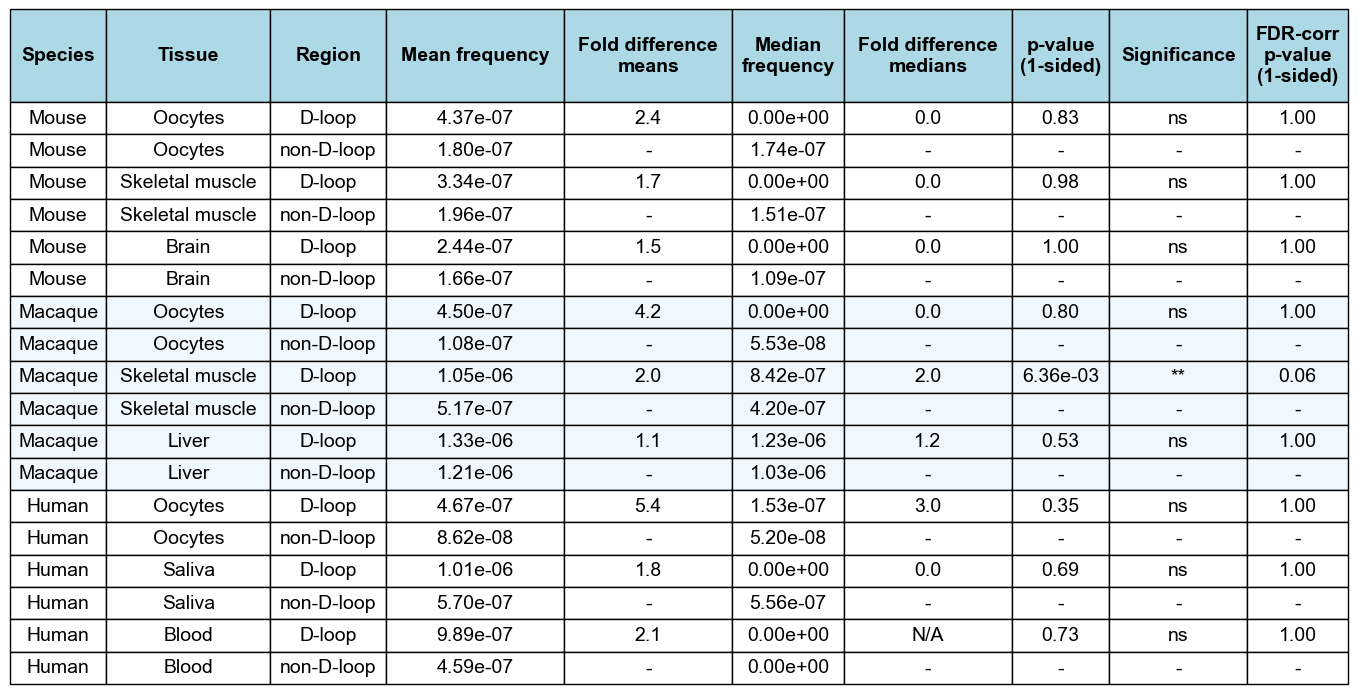

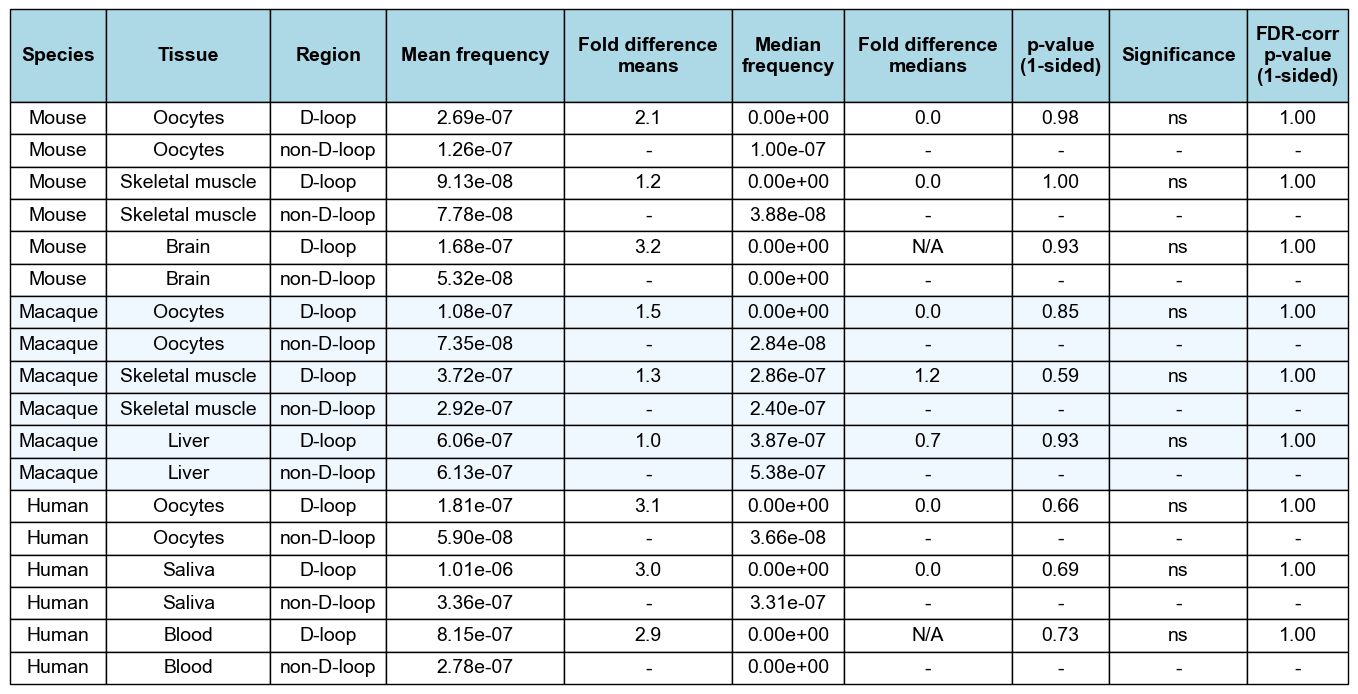

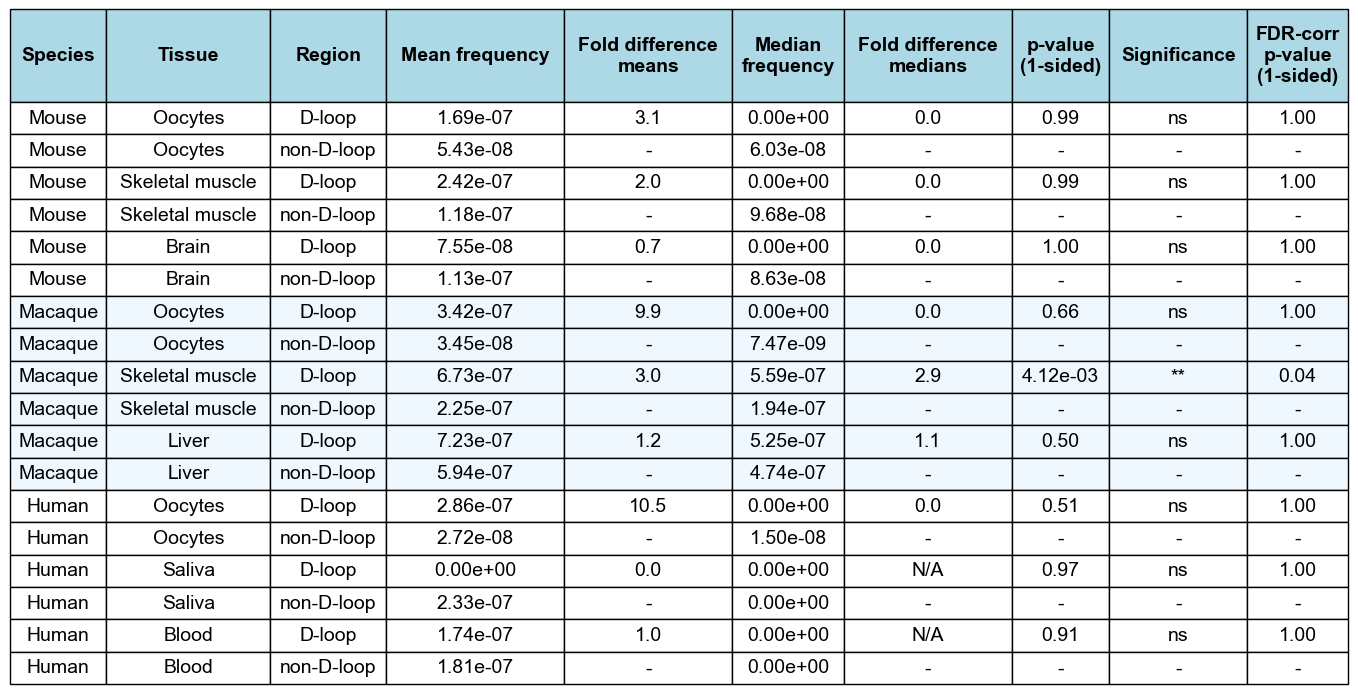

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
# from pandas.plotting import table
import textwrap

# Set the default font to Arial
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'



def enforce_line_breaks_in_headers(df, max_width=20):
    """
    Enforces line breaks in column headers by inserting `\n` when the text exceeds `max_width`.
    """
    # Replace spaces with newlines if the text length exceeds max_width
    df.columns = [
        '\n'.join(textwrap.wrap(col, max_width)) if len(col) > max_width else col
        for col in df.columns
    ]
    return df


def format_nucleotides_column(df, nucl_col='Nucleotides sequenced', folddiff_col='Fold difference medians'):
    """
    Format the 'Nucleotides sequenced' column to display as an integer with commas.
    If the column contains commas, they are removed before conversion.
    Handles both float and integer values.
    """
    if nucl_col in df.columns:
        df[nucl_col] = df[nucl_col].apply(
            lambda x: f"{int(float(str(x).replace(',', '').replace(' ', '').replace('$', ''))):,}" if pd.notnull(x) else ""
        )
    if folddiff_col in df.columns:
        df[folddiff_col] = df[folddiff_col].astype(float).apply(lambda x: f"{x:,.{1}f}")
        df[folddiff_col] = df[folddiff_col].replace({'nan':'N/A','inf':'N/A'})
    return df


def format_long_numbers(df, precision=3):
    """
    Format numbers in the dataframe:
    - Large numbers are formatted with commas (e.g., 1,000,000).
    - Floats smaller than 1 are displayed in scientific notation.
    - Precision for floats is controlled by the 'precision' parameter.
    """
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].apply(lambda x: f"{x:,.{precision}f}" if x >= 0.01 else f"{x:.{precision}e}")
    return df


def replace_tandem_appearances(df_in, index_col='Tissue', folddiff_col='Fold difference medians'):
    df = df_in.copy()
    for col in [ index_col ]:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            # Add an empty string as a valid category
            df[col] = df[col].cat.add_categories([""])
        # Replace tandem appearances with an empty string
        df[col] = df[col].where(df[col].ne(df[col].shift()), "")
    # Columns to conditionally clear based on the index col
    columns_to_clear = [
        folddiff_col, 
        'p-value (1-sided)', 
        'Significance', 
        'FDR-corr p-value (1-sided)'
    ]
    # Clear values in specified columns where the index col is empty
    df[columns_to_clear] = df[columns_to_clear].where(df[index_col] != "", "-")
    # Add back the Mutation type values.
    df[index_col] = df_in[index_col]
    return df


def export_table_as_png(df, file_prefix, spaced_condition_col='Region', folddiff_col='Fold difference medians', save=True):
    df = df.copy()

    # Replace values.
    df = df.replace({'Interm_1':'Intermediate 1', 'Interm_2':'Intermediate 2'})
    df = df.rename(columns={'Indel frequency':'Median frequency'})

    # Format long numbers
    df = format_long_numbers(df, precision=2)

    for col in ['Fold difference medians','Fold difference means']:
        # Apply custom formatting for 'Nucleotides sequenced' column and more
        df = format_nucleotides_column(df, folddiff_col=col)
        # Replace tandem appearances of the specified column with an empty string
        df = replace_tandem_appearances(df, index_col='Tissue', folddiff_col=col)

    # Enforce line breaks in column headers
    df = enforce_line_breaks_in_headers(df, max_width=15)

    # Set the font to Arial and size to 10
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 10

    # Create the figure for the table
    plt.figure(figsize=(10, 6))  # Adjust size as needed

    # Create a table using pandas' built-in functionality
    ax = plt.gca()
    ax.axis('off')  # Turn off axes
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=['lightgrey']*len(df.columns))

    # Adjust column width.
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # Scale the table (header and row scaling) and paint cells
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_fontsize(14)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('lightblue')  # Optional: Set header row color
            cell.set_height(0.2)  # Increase the height of the header rows
        else:  # Data rows
            cell.set_fontsize(14)
            cell.set_height(0.07)  # Increase the height of the header rows
            cell.set_facecolor('white')  # Optional: Set data row color
            
            if df[df['Species']=='Macaque'].shape[0] > 1:
                if df.iloc[i-1]["Species"] == "Macaque":
                    # Paint the entire row
                    cell.set_facecolor('#F0F8FF')
            else:
                # Check the value in the relevant columns for each cell
                if df.iloc[i-1]["Species"] != "":  # If "Species" has a value
                    # Paint the entire row
                    cell.set_facecolor('#F0F8FF')
                elif df.iloc[i-1]["Tissue"] != "":  # If "Tissue" has a value
                    # Paint everything except the "Species" column
                    if j != df.columns.get_loc("Species"):  # Exclude "Species" column
                        cell.set_facecolor('#F0F8FF')  # Set light gray for non-empty "Tissue"
                elif df.iloc[i-1][spaced_condition_col] != "":  # If "Tissue" has a value
                    # Paint everything except the "Species" column
                    if j != df.columns.get_loc("Species") and j != df.columns.get_loc("Tissue"):  # Exclude "Species" and "Tissue" column
                        cell.set_facecolor('#F0F8FF')  # Set light gray for non-empty "Tissue"

    if save:
        # Save table as tsv.
        df.to_csv( f'plots/tsv/{file_prefix}.tsv', index=None, sep='\t' )
        # Save the figure as a vectorized image.
        plt.savefig(f'plots/png/{file_prefix}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'plots/pdf/{file_prefix}.pdf', dpi=300, bbox_inches='tight')
        # plt.close()


export_table_as_png(freqs_a, 'tableS5x_freqsTables_Dloop_including')
export_table_as_png(freqs_b, 'tableS5a_freqsTables_Dloop_excluding')
export_table_as_png(freqs_c, 'tableS5b_freqsTables_Dloop_only')


# Histogram of positions

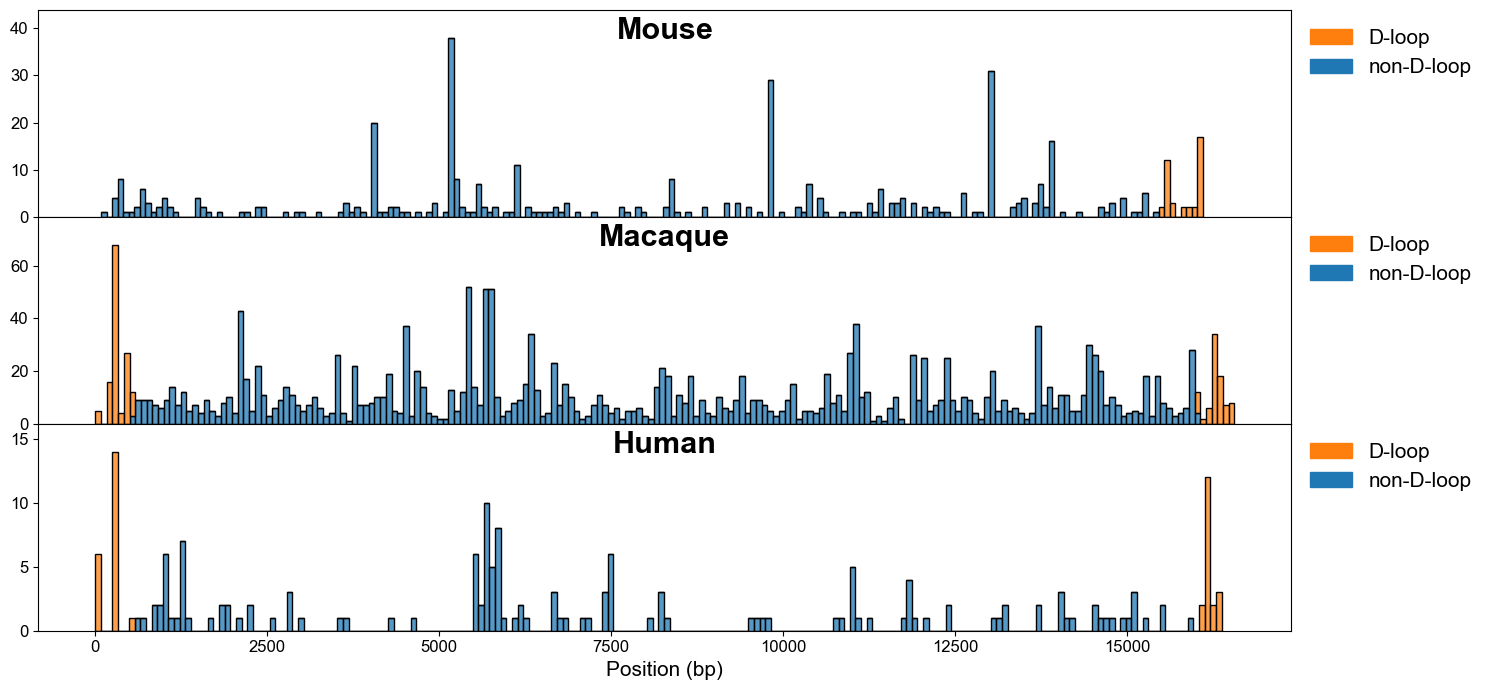

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_hist(df, col='Region', conditions = ['D-loop','non-D-loop'] ):
    gridspec = dict(hspace=0.0)
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=[15, 7], 
                                gridspec_kw=gridspec)
    
    palette = sns.color_palette()
    custom_palette = [palette[1],palette[0]]

    for i,species in enumerate(df.Species.unique()):
        sns.histplot(
                ax = axes[i], 
                data=df[df['Species']==species] , x="POS", hue=col, hue_order=conditions,
                bins=200, linewidth=1, multiple="stack", palette=custom_palette,
            )

        label_fontsize = 15
        # Change axis labels.
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        # Title.
        axes[i].set_title( species.capitalize(), weight='bold', fontsize=22, y=0.82 )
        # Adjust tick label size
        axes[i].tick_params(axis='both', labelsize=label_fontsize*0.8)  # For both x and y ticks

        # Extend ylim by 1.1
        ylim = axes[i].get_ylim()
        axes[i].set_ylim(ylim[0], ylim[1] * 1.1)

        # Create custom legend
        custom_lines = [mpatches.Patch(color=custom_palette[0], label=conditions[0]),
                mpatches.Patch(color=custom_palette[1], label=conditions[1])]
        axes[i].legend(handles=custom_lines, bbox_to_anchor=(1, 1), loc='upper left', frameon=False, fontsize=label_fontsize)
    axes[-1].set_xlabel("Position (bp)", fontsize=label_fontsize)
    plt.tight_layout()

    

plot_hist(df_inc)

# Boxplots

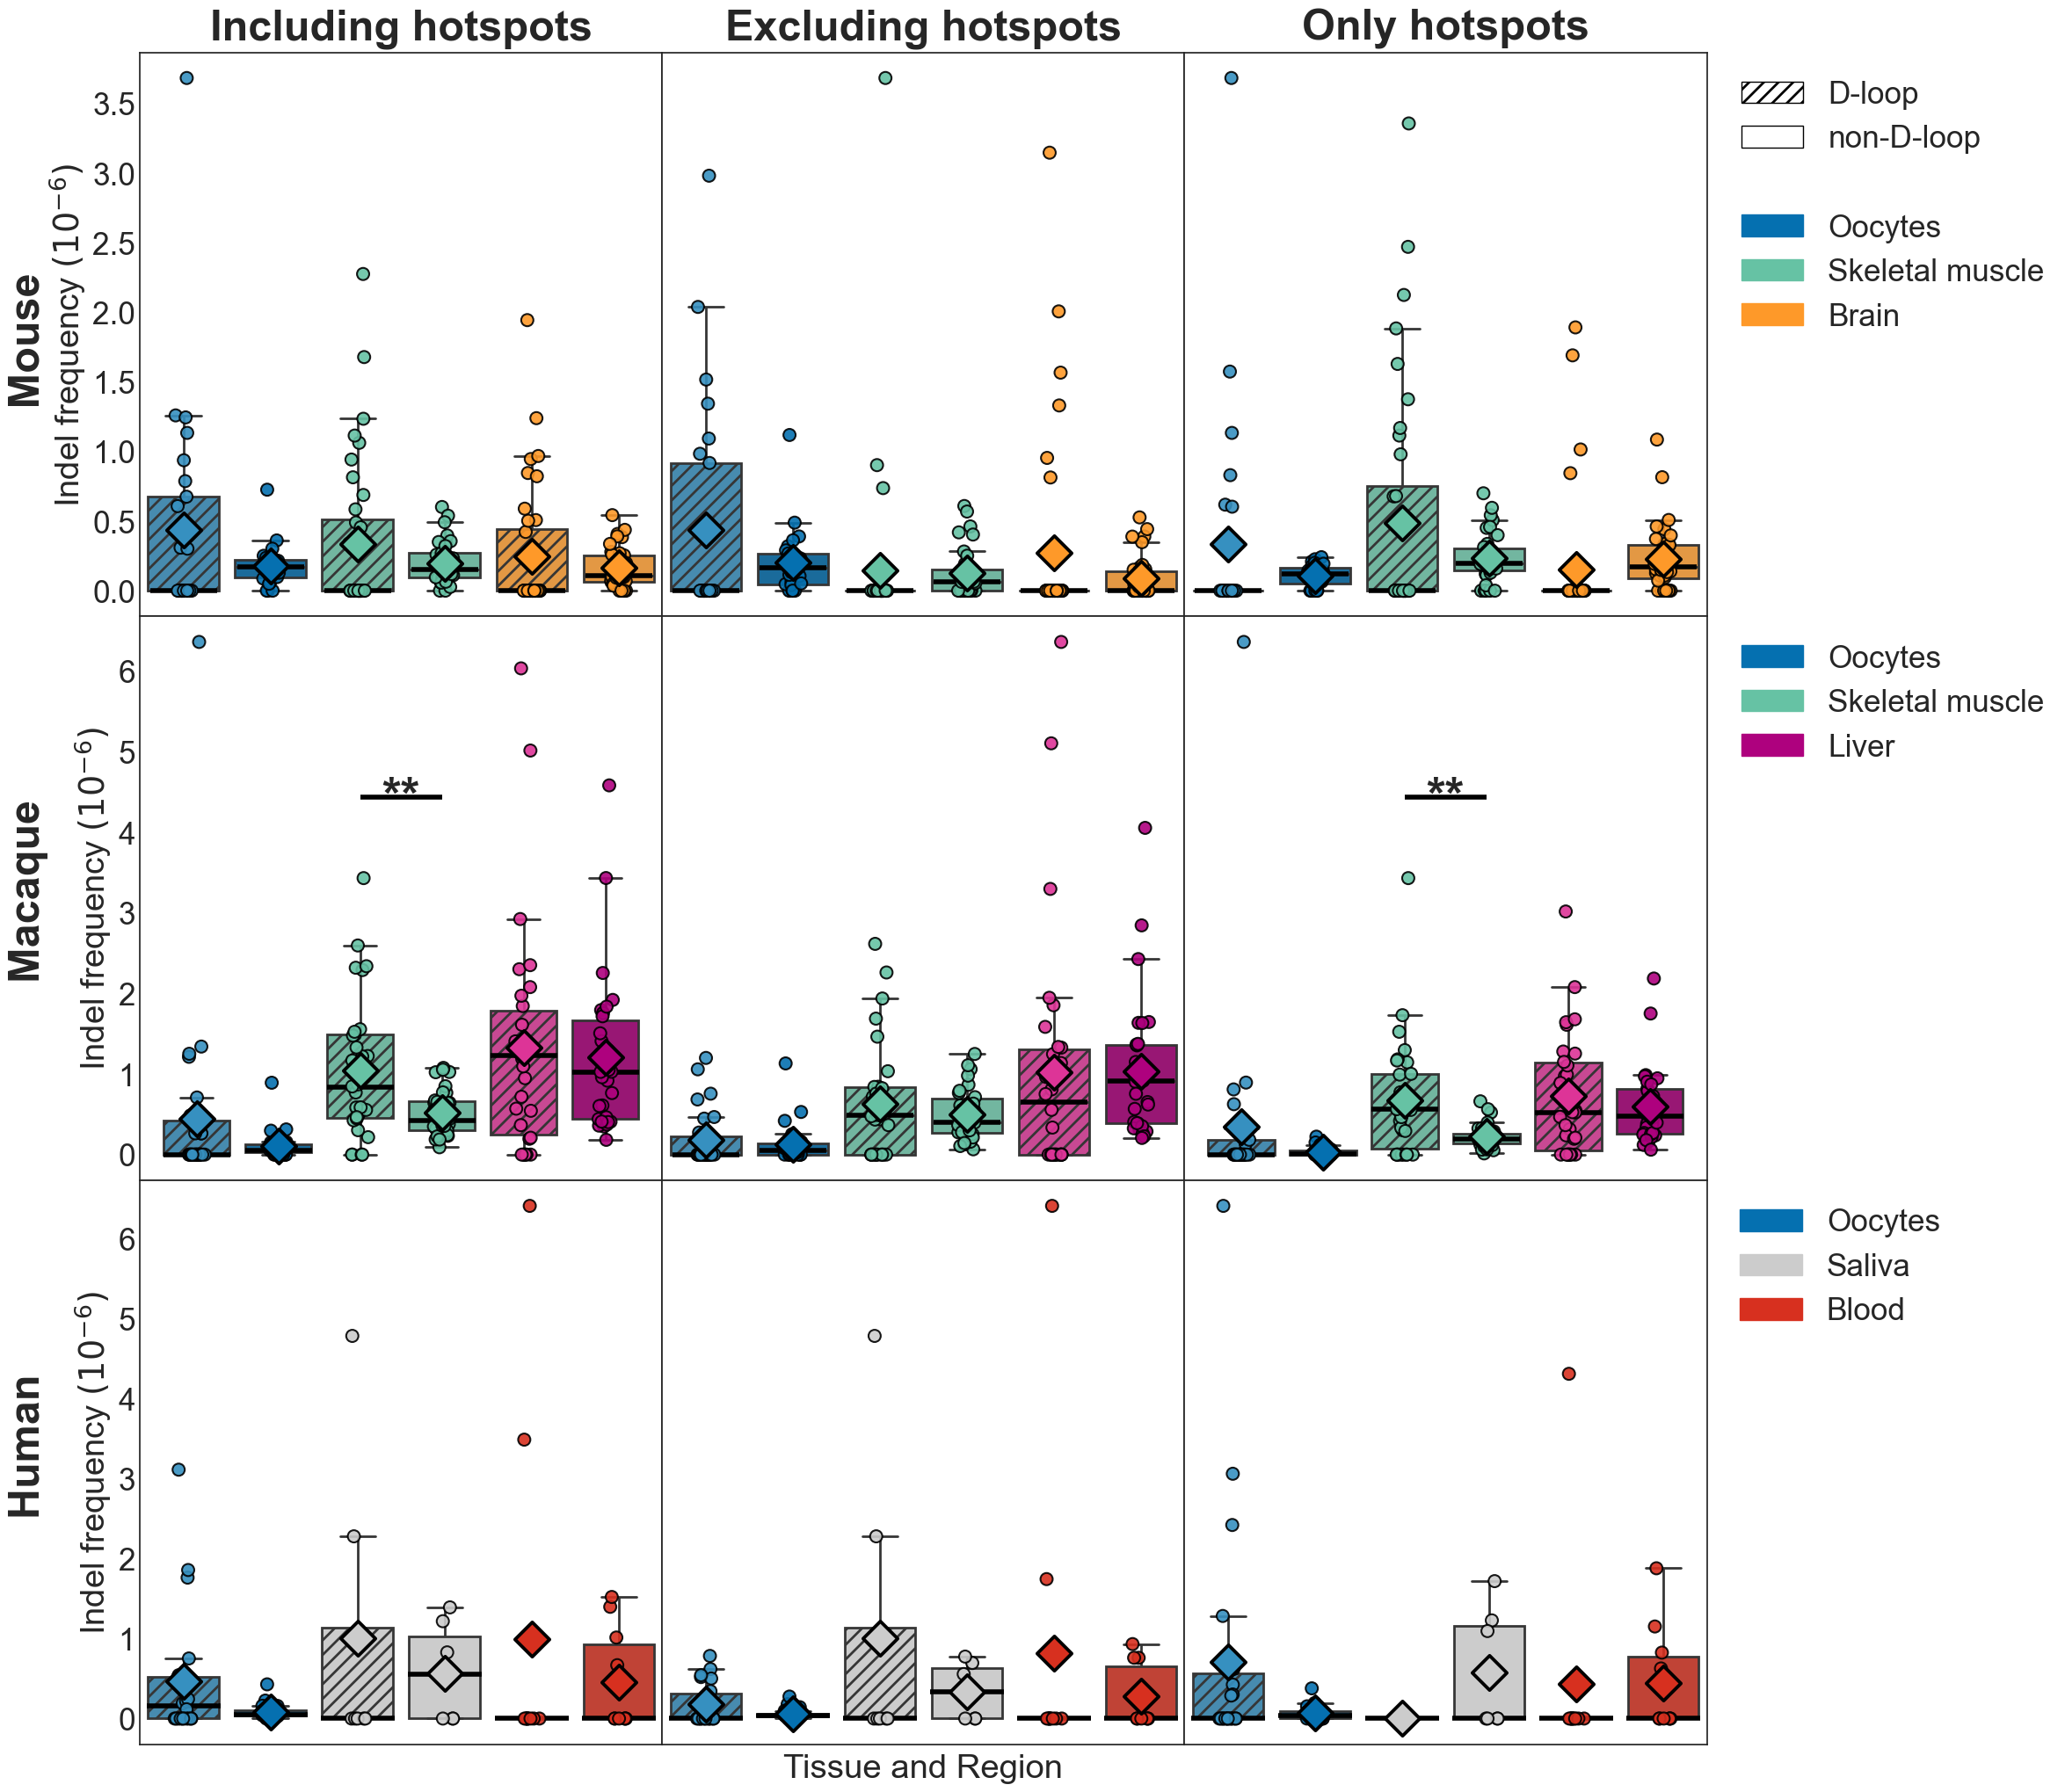

In [23]:
from matplotlib.ticker import MaxNLocator

#%%capture --no-stderr

# Suppress all warnings
warnings.filterwarnings("ignore")

def plot_by_individual(condition_col='Region'):
    if condition_col == 'Region':
        label1='D-loop'
        label2='non-D-loop'
    elif condition_col in ['Age_group','Age group']:
        label1='Younger'
        label2='Older'
    else:
        raise ValueError("# Column name not recognized")

    list_species = ['mouse','macaque','human']
    list_filterVersions = [ 'including', 'excluding', 'only' ]
    
    # Text size (font size) and plot style.
    sns.set(font_scale=2.3)
    plt.style.use('seaborn-v0_8-white')
    #plt.style.use('ggplot')
    
    # Setting the dimensions of the plot.
    fig, axes = plt.subplots(3,3,figsize=(23,25),sharey=False)

    # Adjust space between subplots.
    fig.subplots_adjust(hspace = 0, wspace=0)
    for y,filter_version in enumerate(list_filterVersions):
        # Get indels.
        df_indels = get_indels(filter_version)
        # Get individual-level freqs.
        df_freqs = get_indiv_freqs(df_indels)
        # Make label for plotting.
        df_freqs['Plot_label'] = df_freqs['Species'] +'_'+ df_freqs['Tissue'] +'_'+ df_freqs[condition_col]
        # Change power value of frequencies (Get rid of "1e10-7" in the plot).
        power_value = 6
        #power_value = abs(np.log10(max(df_freqs['Frequency'])).round())
        df_freqs['Frequency'] = df_freqs['Frequency'] * 10**power_value
        
        # Order each label.
        
        custom_order_mou = [f'mouse_Oo_{label1}', f'mouse_Oo_{label2}',
                            f'mouse_M_{label1}',f'mouse_M_{label2}',
                            f'mouse_Br_{label1}',f'mouse_Br_{label2}']
                            
        custom_order_mac = [f'macaque_Oo_{label1}',f'macaque_Oo_{label2}',
                            f'macaque_M_{label1}',f'macaque_M_{label2}',
                            f'macaque_Li_{label1}',f'macaque_Li_{label2}']
                            
        custom_order_hum = [f'human_Oo_{label1}',f'human_Oo_{label2}',
                            f'human_Sa_{label1}',f'human_Sa_{label2}',                      
                            f'human_Bl_{label1}',f'human_Bl_{label2}']
        
        # Custom palette.
        custom_palette_mou = ['#3690c0', '#0570b0',
                              '#66c2a4', '#66c2a4',
                              '#fe9929', '#fe9929']
    
        custom_palette_mac = ['#3690c0','#0570b0',
                              '#66c2a4','#66c2a4',
                              '#dd3497','#ae017e']
        
        custom_palette_hum = ['#3690c0', '#0570b0',
                              '#cccccc', '#cccccc',
                              '#d7301f', '#d7301f']
    
        # Use log scale.
        ##plt.yscale('log')

        # Filter by species.
        def get_species(df,species):
            return df[df['Species']==species].reset_index(drop=True)
    
        # BOX PLOT.
        sns.boxplot( ax = axes[0,y], data = get_species(df_freqs,"mouse"), x = 'Plot_label', y = 'Frequency',
                    order = custom_order_mou, palette = custom_palette_mou, width=0.9, linewidth=2, fliersize=0, gap = 0.1 ) 
        sns.boxplot( ax = axes[1,y], data = get_species(df_freqs,"macaque"), x = 'Plot_label', y = 'Frequency',
                    order = custom_order_mac, palette = custom_palette_mac, width=0.9, linewidth=2, fliersize=0, gap = 0.1 ) 
        sns.boxplot( ax = axes[2,y], data = get_species(df_freqs,"human"), x = 'Plot_label', y = 'Frequency',
                    order = custom_order_hum, palette = custom_palette_hum, width=0.9, linewidth=2, fliersize=0, gap = 0.1 )
        
        # Add hatches (stripes) to boxplots.
        plt.rcParams['hatch.linewidth'] = 2.0
        for n in [0,1,2,3,4,5,6,7,8]:
            bars = fig.axes[n].patches
            hatches=['//',None,'//',None,'//',None]
            for pat,bar in zip(hatches,bars):
                bar.set_hatch(pat)

        # STRIP PLOT of median indel frequencies (reinforces boxplot lines).
        marker_size = 60
        df_medians = pd.DataFrame(get_species(df_freqs,'mouse').groupby(by=['Species','Tissue',condition_col,'Plot_label'])['Frequency'].median())
        sns.stripplot( ax = axes[0,y], data = df_medians, x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0, edgecolor='black', linewidth=4, alpha=1, s=marker_size-5, marker="_",
                      order = custom_order_mou, color = 'black' )
        df_medians = pd.DataFrame(get_species(df_freqs,'macaque').groupby(by=['Species','Tissue',condition_col,'Plot_label'])['Frequency'].median())
        sns.stripplot( ax = axes[1,y], data = df_medians, x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0, edgecolor='black', linewidth=4, alpha=1, s=marker_size-5, marker="_",
                      order = custom_order_mac, color = 'black' )
        df_medians = pd.DataFrame(get_species(df_freqs,'human').groupby(by=['Species','Tissue',condition_col,'Plot_label'])['Frequency'].median())
        sns.stripplot( ax = axes[2,y], data = df_medians, x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0, edgecolor='black', linewidth=4, alpha=1, s=marker_size, marker="_",
                      order = custom_order_hum, color = 'black' )

        # STRIP PLOT of individual frequencies.
        np.random.seed(123)
        dot_size = 10
        sns.stripplot( ax = axes[0,y], data = get_species(df_freqs,'mouse'), x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0.1, edgecolor='black', linewidth=1.5, s=dot_size,
                      order = custom_order_mou, palette = custom_palette_mou, alpha=0.9 )
        sns.stripplot( ax = axes[1,y], data = get_species(df_freqs,'macaque'), x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0.1, edgecolor='black', linewidth=1.5, s=dot_size,
                      order = custom_order_mac, palette = custom_palette_mac, alpha=0.9 )
        sns.stripplot( ax = axes[2,y], data = get_species(df_freqs,'human'), x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0.1, edgecolor='black', linewidth=1.5, s=dot_size,
                      order = custom_order_hum, palette = custom_palette_hum, alpha=0.9 )

        # STRIP PLOT of mean indel frequencies from individuals.
        diamond_size = 20
        marker = "D"
        df_means = pd.DataFrame(get_species(df_freqs,'mouse').groupby(by=['Species','Tissue',condition_col,'Plot_label'])['Frequency'].mean())
        sns.stripplot( ax = axes[0,y], data = df_means, x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0, edgecolor='black', linewidth=2.75, alpha=1, s=diamond_size, marker=marker,
                      order = custom_order_mou, palette = custom_palette_mou )
        df_means = pd.DataFrame(get_species(df_freqs,'macaque').groupby(by=['Species','Tissue',condition_col,'Plot_label'])['Frequency'].mean())
        sns.stripplot( ax = axes[1,y], data = df_means, x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0, edgecolor='black', linewidth=2.75, alpha=1, s=diamond_size, marker=marker,
                      order = custom_order_mac, palette = custom_palette_mac )
        df_means = pd.DataFrame(get_species(df_freqs,'human').groupby(by=['Species','Tissue',condition_col,'Plot_label'])['Frequency'].mean())
        sns.stripplot( ax = axes[2,y], data = df_means, x = 'Plot_label', y = 'Frequency',
                      dodge=False, jitter=0, edgecolor='black', linewidth=2.75, alpha=1, s=diamond_size, marker=marker,
                      order = custom_order_hum, palette = custom_palette_hum )
        
        
        ### Add SIGNIFICANCE markers. ###
        results_test = perform_statistical_test(df_freqs)
        # fet_table = pd.read_table(f'tables/freqs.fisher_test_{filter_version}Hotspots.txt')
        # fet_table = fishers_test_on_freqs( df_indels )
        # Filter by tissue.
        def get_tissue(df,tissue):
            return df[df['Tissue']==tissue].reset_index(drop=True)
        # Filter by age group.
        def get_condition(df,cond):
            return df[df[condition_col]==cond].reset_index(drop=True)
        for i,species in enumerate(['mouse','macaque','human']):
            list_tissue = {'mouse':['Oo','M','Br'],
                'macaque':['Oo','M','Li'],
                'human':['Oo','Sa','Bl']}[species]
            dict_tissue = {'Oo':'Oocytes','M':'Skeletal muscle','Br':'Brain',
                'Li':'Liver','Sa':'Saliva','Bl':'Blood'}
            for j,tissue in enumerate(list_tissue):
                filtered_data = get_tissue(get_species(df_freqs,species),tissue)
                #df_freqs[(df_freqs['Species'] == species) & (df_freqs['Tissue'] == tissue)]
                # Perform t-test between Younger and Older age groups
                values1 = filtered_data[filtered_data[condition_col] == label1]['Frequency']
                values2 = filtered_data[filtered_data[condition_col] == label2]['Frequency']
                p_value = float(get_condition(get_tissue(get_species(results_test,species),tissue),label2)['P_value'])
                # Assign stars by significance level
                if p_value < 0.001:
                    stars = "***"
                elif p_value < 0.01:
                    stars = "**"
                elif p_value < 0.05:
                    stars = "*"
                else:
                    continue  # Not significant (if p-value >= 0.05)

                line_y_int = 1
                # # # Lines.
                # # axes[i,y].plot([j*2,j*2+1], [max(max(values1), max(values2)) + line_y_int, max(max(values1), max(values2)) + line_y_int], color='black', lw=4, solid_capstyle='butt')
                # if species == 'mouse' and tissue == 'Oo'and filter_version in ['including','excluding']:
                #     line_y_int = -3
                #     # Stars.
                #     axes[i,y].text(0.5+j*2, max(max(values1), max(values2)) + line_y_int-0.3, stars, fontweight='bold', 
                #     horizontalalignment='center', verticalalignment='bottom', fontsize=40)
                #     # Lines.
                #     axes[i,y].plot([j*2,j*2+1], [max(max(values1), max(values2)) + line_y_int, max(max(values1), max(values2)) + line_y_int], color='black', lw=4, solid_capstyle='butt')
                # elif species == 'macaque':
                #     if tissue == 'M' and filter_version == 'including':
                #         line_y_int = -12
                #         # Stars.
                #         axes[i,y].text(0.5+j*2, max(max(values1), max(values2)) + line_y_int-2, stars, fontweight='bold', 
                #         horizontalalignment='center', verticalalignment='bottom', fontsize=40)
                #         # Lines.
                #         axes[i,y].plot([j*2,j*2+1], [max(max(values1), max(values2)) + line_y_int, max(max(values1), max(values2)) + line_y_int], color='black', lw=4, solid_capstyle='butt')
                #     else:
                #         line_y_int = 2
                #         # Stars.
                #         axes[i,y].text(0.5+j*2, max(max(values1), max(values2)) + line_y_int-2, stars, fontweight='bold', 
                #         horizontalalignment='center', verticalalignment='bottom', fontsize=40)
                #         # Lines.
                #         axes[i,y].plot([j*2,j*2+1], [max(max(values1), max(values2)) + line_y_int, max(max(values1), max(values2)) + line_y_int], color='black', lw=4, solid_capstyle='butt')
                    
                # else:
                #     line_y_int = 0.5
                # Stars.
                axes[i,y].text(0.5+j*2, max(max(values1), max(values2)) + line_y_int-0.3, stars, fontweight='bold', 
                horizontalalignment='center', verticalalignment='bottom', fontsize=40)
                # Lines.
                axes[i,y].plot([j*2,j*2+1], [max(max(values1), max(values2)) + line_y_int, max(max(values1), max(values2)) + line_y_int], color='black', lw=4, solid_capstyle='butt')


        # # Change titles.
        #title_size = 32
        #axes[0,y].set_title( "Mouse", fontsize=title_size, y = 0.9, rotation = 0)
        #axes[1,y].set_title( "Macaque", fontsize=title_size, y = 0.9, rotation = 0)
        #axes[2,y].set_title( "Human", fontsize=title_size, y = 0.9, rotation = 0)
    
        # Change axis labels.
        axes[0,y].set_xlabel('')
        axes[1,y].set_xlabel('')
        axes[2,y].set_xlabel('')
        axes[0,y].set_ylabel(r'Indel frequency $(10^{-%i})$' %power_value)
        axes[1,y].set_ylabel(r'Indel frequency $(10^{-%i})$' %power_value)
        axes[2,y].set_ylabel(r'Indel frequency $(10^{-%i})$' %power_value)

        # Remove x tick labels.
        [ axes[y,x].set_xticklabels('') for x in [0,1,2] ]

    # Row-specific ylim values
    row_ylims = {
        0: (-0.1, 1.5),
        1: (-0.1, 4.0),
        2: (-0.1, 2.0)
    }
    for i, row in enumerate(range(3)):
        for j, col in enumerate(range(3)):
            ax = axes[i, j]
            # ax.set_ylim(row_ylims[i]) # Change y-limits
            if j > 0:
                ax.set_ylabel("")  # Remove redundant y-axis labels for better clarity
                ax.set_yticklabels([])

    # percentage_raise = 1.02
    # [ axes[x,y].set_ylim([ axes[x,y].get_ylim()[0], axes[x,y].get_ylim()[1]*percentage_raise ]) for x in [0,1,2] ]

    # Force axes[2,0] tick labels to be integers.
    axes[2,0].yaxis.set_major_locator(MaxNLocator(integer=True))

    # Change legends.
    slashed_patch = mpatches.Patch( label=label1,edgecolor='#000000', facecolor='#FFFFFF', hatch='//')
    white_patch = mpatches.Patch( label=label2,edgecolor='#000000', facecolor='#FFFFFF', hatch=None)
    blank_patch = mpatches.Patch(color='#FFFFFF', label='')

    first_patch = mpatches.Patch(color=custom_palette_mou[1], label='Oocytes')
    second_patch = mpatches.Patch(color=custom_palette_mou[3], label='Skeletal muscle')
    third_patch = mpatches.Patch(color=custom_palette_mou[5], label='Brain')
    axes[0,2].legend(
        handles=[slashed_patch,white_patch,blank_patch,first_patch,second_patch,third_patch], 
        bbox_to_anchor=(1.7, 1.0)
        )
    first_patch = mpatches.Patch(color=custom_palette_mac[1], label='Oocytes')
    second_patch = mpatches.Patch(color=custom_palette_mac[3], label='Skeletal muscle')
    third_patch = mpatches.Patch(color=custom_palette_mac[5], label='Liver')
    axes[1,2].legend(
        handles=[first_patch,second_patch,third_patch], 
        bbox_to_anchor=(1.7, 1.0)
        )
    first_patch = mpatches.Patch(color=custom_palette_hum[1], label='Oocytes')
    second_patch = mpatches.Patch(color=custom_palette_hum[3], label='Saliva')
    third_patch = mpatches.Patch(color=custom_palette_hum[5], label='Blood')
    axes[2,2].legend(
        handles=[first_patch,second_patch,third_patch], 
        bbox_to_anchor=(1.5, 1.0)
        )

    # Titles.
    title_size = 35
    #fig.suptitle( '           '.join(dict_DFs.keys()), 
    #              weight="bold", size=title_size, y=0.9
    #            )
    plt.suptitle( '                                 '.join(reversed([ x.capitalize() for x in list_species])), 
              weight="bold", size=title_size, y=0.78, x=0.07, rotation=90 
           )
    dict_filterVersions = {
        'including':'Including hotspots', 'excluding':'Excluding hotspots', 'only':'Only hotspots'
    }
    [ axes[0,n].set_title( dict_filterVersions[list_filterVersions[n]], fontsize=title_size, y = 1.01, rotation = 0, weight="bold") for n in [0,1,2] ]

    axes[2,1].set_xlabel( f"Tissue and {condition_col}", y = 1, rotation = 0)

    # Export as vectorized image.
    plt.savefig(f'plots/png/figureS6_boxplot_dloop_{alignment}.png', bbox_inches='tight', format='png', dpi=600)
    plt.savefig(f'plots/pdf/figureS6_boxplot_dloop_{alignment}.pdf', bbox_inches='tight', format='pdf', dpi=600)

    plt.show()


# # Allow all warnings
# warnings.filterwarnings("default")


plot_by_individual()